In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import torch

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

import utils.torchUtils as gnn

In [2]:
bkgtrees = ObjIter([Tree(fc.eightb.preselection.QCD_B_List)])

In [3]:
# signaltrees = ObjIter([Tree(fc.eightb.preselection.signal_list[i]) for i in (0,4,7)])
signaltrees = ObjIter([Tree(fc.eightb.preselection.signal_list[i]) for i in (0,4,7)])

In [4]:
for tree in signaltrees: tree.color=None

In [5]:
gnn.config.set_gpu(False)

In [6]:
model_paths = [
    # "/uscms_data/d3/ekoenig/8BAnalysis/studies/sixbStudies/jupyter/eightb/graph_net/models/golden_knn/lightning_logs/version_0/checkpoints/epoch=10-step=3970.ckpt"
    "/uscms_data/d3/ekoenig/8BAnalysis/studies/sixbStudies/jupyter/eightb/graph_net/models/golden_knn/lightning_logs/version_1/checkpoints/epoch=11-step=4331.ckpt"
]


In [7]:
model = gnn.modelMap['golden_knn'].load_from_checkpoint(model_paths[-1]).to(device=gnn.config.device)

In [8]:
from torch_geometric.data import Data

class Predict(gnn.BaseTransform):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def _predict_center_(self, data, center):
        center_mask = (data.edge_index == center).any(dim=0)
        edge_mask = data.edge_mask
        data.edge_mask = edge_mask & center_mask
        _, edge_o = self.model.predict(data)
        data.edge_mask = edge_mask
        edge_o = edge_o[center_mask]
        edges  = data.edge_index[:,center_mask]
        max_edge = torch.argmax(edge_o)
        score = edge_o[max_edge]
        edge = edges[:,max_edge]
        return torch.cat([score[None], edge])
    def __call__(self, data : Data) -> Data:
        out = torch.stack([ self._predict_center_(data, center) for center in range(data.num_nodes) ])
        score, pair_index = out[:,0], out[:,1:].long().T
        data.score = score
        data.pair_index = pair_index 
        return data

In [9]:
transform = gnn.Transform()
transform.append(gnn.min_edge_neighbor(n_neighbor=model.hparams['n_neighbor'], undirected=True))
template = gnn.Dataset("../data/template",make_template=True, transform=transform)

In [10]:
def get_tree_graph(tree, ver='testing', path='../data'):
    sample = tree.sample
    dataset = gnn.Dataset(f'{path}/{sample}-{ver}', transform=template.transform+Predict(model))
    loader = gnn.DataLoader(dataset, batch_size=50, num_workers=gnn.config.ncpu)
    tree.graphs = loader

def get_qcd_graph(tree, path='../data'):
    get_name = lambda f : f.fname.split('/')[-2]
    dataset = gnn.concat_dataset([f'{path}/{sample}' for sample in map(get_name, tree.filelist)],transform=template.transform+Predict(model))
    loader = gnn.DataLoader(dataset, batch_size=50, num_workers=gnn.config.ncpu)
    tree.graphs = loader

In [11]:
signaltrees.apply(get_tree_graph)
bkgtrees.apply(get_qcd_graph)

[None]

In [12]:
dataset = signaltrees[0].graphs

In [13]:
data = dataset.dataset[0]
for batch in dataset: break

In [19]:
_, data_o = model.predict(data)
_,batch_o = model.predict(batch)

In [22]:
data_o - batch_o[:100]

tensor([-3.0734e-08,  0.0000e+00,  0.0000e+00,  0.0000e+00, -3.8743e-07,
         0.0000e+00, -1.0710e-08,  1.2506e-12, -2.3647e-11, -1.0914e-11,
         0.0000e+00,  3.0292e-27,  0.0000e+00,  0.0000e+00, -2.4937e-18,
         0.0000e+00,  0.0000e+00,  8.7350e-22,  5.6921e-19,  1.8431e-18,
         0.0000e+00,  0.0000e+00, -4.1723e-07, -1.8190e-11,  0.0000e+00,
        -1.2790e-13,  0.0000e+00,  0.0000e+00,  0.0000e+00, -2.0373e-10,
         0.0000e+00,  0.0000e+00, -1.8190e-11, -1.5179e-18, -1.2434e-13,
        -6.9118e-19, -1.0516e-12, -7.4940e-16,  0.0000e+00,  0.0000e+00,
        -3.8743e-07, -2.4937e-18,  0.0000e+00, -1.2434e-13, -8.6427e-07,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00, -1.2790e-13, -6.9118e-19,  0.0000e+00,
         1.2705e-21,  5.3291e-15,  7.3184e-19,  0.0000e+00,  0.0000e+00,
        -1.0710e-08,  0.0000e+00,  0.0000e+00, -1.0516e-12,  0.0000e+00,
         5.3291e-15,  0.0000e+00,  0.0000e+00,  0.0

In [14]:
def predict_dataset(dataset):
    score, pair_index = [], []
    for i,batch in enumerate(dataset):
        n_nodes = batch.ptr[1:]-batch.ptr[:-1]
        offset = torch.repeat_interleave(batch.ptr[:-1], n_nodes)
        score.append(batch.score)
        pair_index.append(batch.pair_index - offset)
    score = torch.cat(score).cpu().numpy()
    pair_index = torch.cat(pair_index, dim=-1).T.cpu().numpy()
    return score, pair_index

def predict_tree(tree):
    score, pairs = predict_dataset(tree.graphs)
    n_jet = tree.n_jet
    score = ak.unflatten(score, n_jet)
    pairs = ak.unflatten(pairs, n_jet)
    tree.extend(edge_score=score, edge_pair=pairs)

In [15]:
predict_tree(signaltrees[0])

In [16]:
tree = signaltrees[0]

In [17]:
build_all_dijets(tree, tree.edge_pair)

In [18]:
def std_edge_score(tree):
    max_edges = ak.max(tree.edge_score, axis=-1)
    min_edges = ak.min(tree.edge_score, axis=-1)
    tree.extend(std_edge_score=(tree.edge_score - min_edges)/(max_edges - min_edges))
std_edge_score(tree)

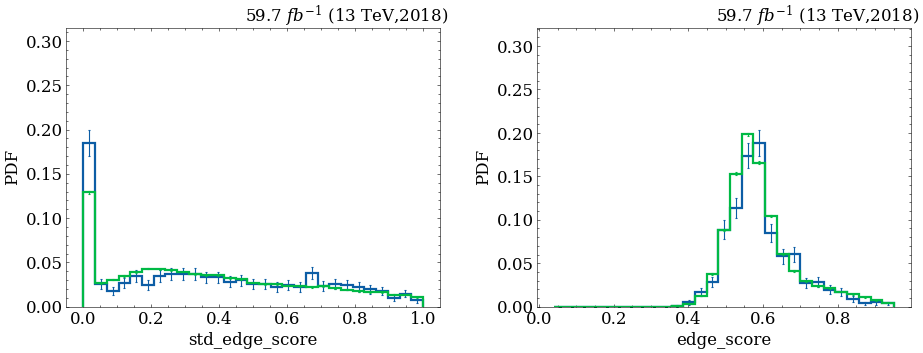

In [20]:
study.quick(
    [tree, tree],
    masks=[lambda t: (t.nfound_presel==8)&(t.dijet_signalId>-1), lambda t:(t.nfound_presel==8)&(t.dijet_signalId==-1)],
    varlist=['std_edge_score','edge_score'], density=True,
)